In [93]:
import pandas as pd
import spacy
from collections import Counter
import itertools
import re
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [94]:
# Załadowanie modelu języka polskiego
nlp = spacy.load('pl_core_news_md')
opinions = pd.read_csv('csv_data/preprocesed_files/anomaly_opinions.csv')
# Pobranie zawartości kolumny "content" jako listy zdań
sentences = opinions['content'].tolist()

In [95]:
opinions = pd.read_csv('csv_data/preprocesed_files/all_opinions_merged.csv')
# Tworzenie listy krotek
opinions_list = [(row['content'], row['doubleQuality']) for _, row in opinions.iterrows()]
random.shuffle(opinions_list)

In [96]:
def unique_words_in_csv(sentences):
    lem_counter = Counter()
    for content in sentences:
        doc = nlp(content)

        for token in doc:
            if token.is_alpha and (not token.is_stop or token.lower_ == "niż" or token.lower_ == "od"):
                lem_counter[token.lemma_.lower()] += 1

    lemmas_count = list(zip(lem_counter.keys(), lem_counter.values()))
    sorted_lemmas_count = sorted(lemmas_count, key=lambda x: x[1], reverse=True)
    return sorted_lemmas_count


In [97]:
lemmas_count = unique_words_in_csv(sentences)
len(lemmas_count)

766

In [98]:
def print_lemmas_in_dataset(sorted_lemmas_count):
    # Przygotowanie danych do wykresu
    words = [lemma for lemma, count in sorted_lemmas_count if count > 5]
    counts = [count for lemma, count in sorted_lemmas_count if count > 5]

    # Generowanie wykresu słupkowego
    plt.figure(figsize=(10, 6))  # Zmiana rozmiaru wykresu
    plt.bar(range(len(words)), counts)
    plt.xticks(range(len(words)), words, rotation=45, ha='right')  # Obrót etykiet o 45 stopni
    plt.xlabel("Unikalne Słowa")
    plt.ylabel("Częstość występowania")
    plt.title("Częstość występowania unikalnych słów (częstość > 5)")
    plt.tight_layout()
    plt.show()

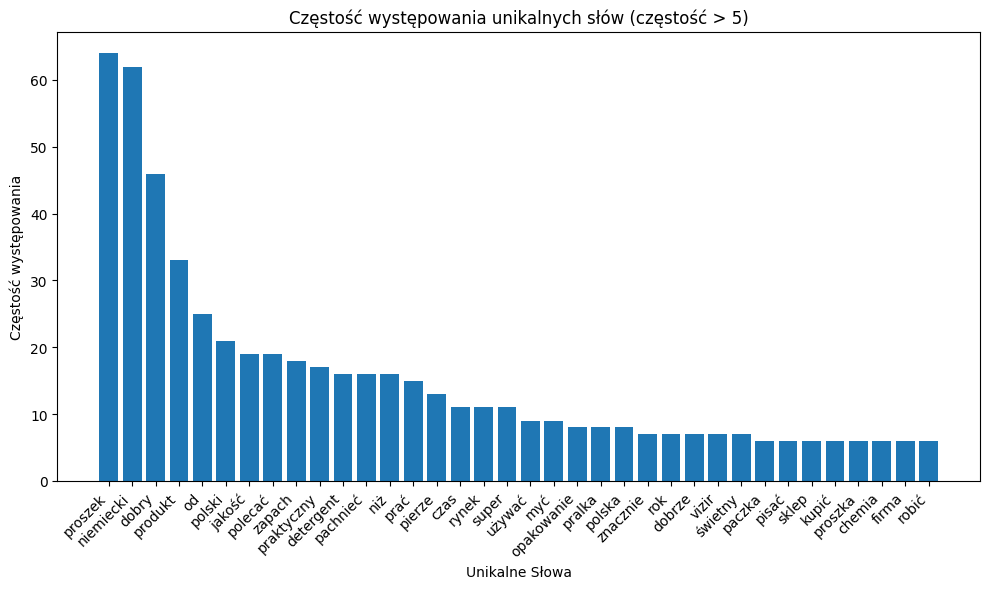

In [99]:
print_lemmas_in_dataset(lemmas_count)

In [100]:
# Inicjalizacja pustej listy
lemmas = []

# Iteracja po liście lemmas_count
for lemma, count in lemmas_count:
    if count > 5:
        lemmas.append(lemma)
len(lemmas)

36

In [101]:
def create_combinations(manually_selected_lemmas, lemmas):
    combinations = set()

    # Pary z manually_selected_lemmas i lemmas
    for lemma1 in manually_selected_lemmas:
        for lemma2 in lemmas:
            combination = tuple(sorted([lemma1, lemma2]))
            combinations.add(combination)

    # Pary z lemmas
    for lemma1 in lemmas:
        for lemma2 in lemmas:
            if lemma1 != lemma2:
                combination = tuple(sorted([lemma1, lemma2]))
                combinations.add(combination)

    # Usunięcie duplikatów i par z identycznymi słowami
    combinations = {(lemma1, lemma2) for lemma1, lemma2 in combinations if lemma1 != lemma2}

    return combinations


In [102]:
manually_selected_lemmas = ["niż", "lepszy", "lepiej", "rynek", "jakość", "znacznie", "od"]

combinations = create_combinations(manually_selected_lemmas, lemmas)

for combination in combinations:
    print(combination)

print("Liczba kombinacji:", len(combinations))

('chemia', 'pisać')
('lepiej', 'niemiecki')
('firma', 'myć')
('pachnieć', 'polecać')
('niż', 'sklep')
('myć', 'polecać')
('pachnieć', 'pierze')
('myć', 'pierze')
('robić', 'zapach')
('jakość', 'świetny')
('lepszy', 'robić')
('firma', 'proszka')
('dobry', 'polecać')
('proszek', 'świetny')
('kupić', 'pachnieć')
('polski', 'pralka')
('paczka', 'proszek')
('firma', 'rynek')
('dobry', 'pierze')
('pierze', 'proszka')
('chemia', 'opakowanie')
('proszka', 'vizir')
('pierze', 'rynek')
('chemia', 'świetny')
('polska', 'zapach')
('dobrze', 'kupić')
('produkt', 'proszek')
('lepszy', 'rok')
('detergent', 'dobrze')
('paczka', 'prać')
('dobrze', 'pachnieć')
('jakość', 'znacznie')
('polski', 'produkt')
('opakowanie', 'używać')
('dobry', 'lepszy')
('lepszy', 'polska')
('proszek', 'znacznie')
('kupić', 'zapach')
('paczka', 'robić')
('dobry', 'dobrze')
('firma', 'polecać')
('niemiecki', 'zapach')
('firma', 'pierze')
('pierze', 'polecać')
('niż', 'pachnieć')
('czas', 'zapach')
('polecać', 'praktyczny')
('

In [103]:
def rule_based_double_quality_search(opinions, combinations):
    total_sentences = len(opinions)
    true_positives = 0
    false_positives = 0
    true_negatives = 0
    false_negatives = 0

    for txt in opinions:
        # Przetworzenie zdania na tokeny
        doc = nlp(txt[0])

        # Tworzenie listy lematów zdania
        lemmas = [token.lemma_.lower() for token in doc]

        # Tworzenie kombinacji lematów zdania
        sentence_combinations = set()
        for lemma1, lemma2 in combinations:
            if lemma1 in lemmas and lemma2 in lemmas:
                sentence_combinations.add((lemma1, lemma2))

        # Sprawdzenie liczby kombinacji
        if len(sentence_combinations) > 10:
            if txt[1] == 1:
                true_positives += 1
            else:
                false_positives += 1
        else:
            if txt[1] == 0:
                true_negatives += 1
            else:
                false_negatives += 1
    
    print("Liczba zdań ze zbioru: ", total_sentences)
    print("TP: ", true_positives)
    print("FN: ", false_negatives)
    print("FP: ", false_positives)
    print("TN: ", true_negatives)
    
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)
    loss = (false_positives + false_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
      
    print("Miary:")
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("Accuracy: ", accuracy)
    print("Loss: ", loss)
    print("F1: ", f1_score)


    confusion_matrix = [[true_positives, false_negatives], [false_positives, true_negatives]]

    # Wykreślenie Confusion Matrix
    sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

Liczba zdań ze zbioru:  33197
TP:  31
FN:  76
FP:  299
TN:  32791
Miary:
Precision:  0.09393939393939393
Recall:  0.2897196261682243
Accuracy:  0.9887037985360123
Loss:  0.01129620146398771
F1:  0.14187643020594964


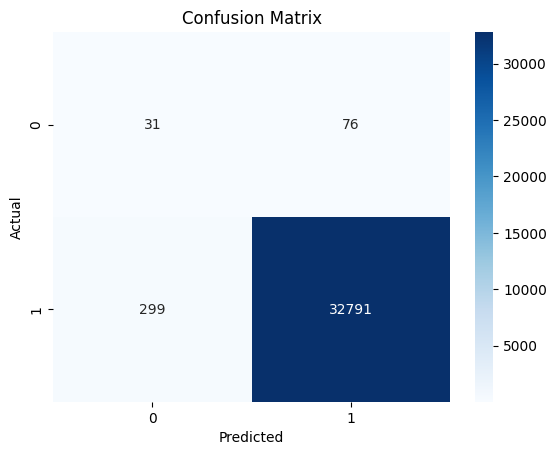

In [104]:
rule_based_double_quality_search(opinions_list, combinations)